# Prepare data for training
To-do:
- preload images
- separate images into train and test set (maybe 90:10)

In [1]:
import tensorflow as tf

import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from pathlib import Path

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

from sklearn.utils import class_weight

import sys
sys.path.append(r"/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification")

import brain_mets_classification.custom_funcs as funcs

from tqdm import tqdm

CAVE: remove patient sub-01383503 from training as the cerebellum is not fully displayed

In [3]:
path_to_patients_tsv = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/rawdata/participants.tsv")

# old: path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_brainlesion_allpatients")
path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_brainlesion_allpatients")

Read .tsv file with all the patients

In [4]:
training_patients = pd.read_csv(path_to_patients_tsv, sep="\t", index_col=False)

# drop patient sub-01383503
patient_to_drop_index = training_patients.index[training_patients["participant_id"] == "sub-01383503"]
training_patients.drop(index=patient_to_drop_index, inplace=True)
training_patients.reset_index(drop=True, inplace=True)
#training_patients = training_patients.sample(frac=1) #shuffles the dataset

print(f"Before removing unfit files: {len(training_patients)}")
patient_files_list = os.listdir(path_to_preprocessed_images)
for index, row in training_patients.iterrows():
    if training_patients["participant_id"][index] not in patient_files_list:
        training_patients.drop(index=index, inplace=True)

print(f"After removing unfit files: {len(training_patients)}")
training_patients.reset_index(drop=True, inplace=True)

Before removing unfit files: 493
After removing unfit files: 491


### Unify primary classes

In [50]:
# primaries are written like this: 1e, 25, 13, 2f, etc., for the full list see config.py
# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
primaries_array = training_patients["primary"]
#print(primaries_array.value_counts())

def compress_primaries(primaries_array):
    '''moves all the primaries from different subclasses into one class, e.g. 1a-f become 1 etc.'''
    
    letters_removed_primaries = []

    # remove any letters from the list
    for primary in primaries_array:
        clean_primary = ''.join(filter(str.isdigit, primary))
        letters_removed_primaries.append(clean_primary)

    compressed_primaries = []

    for primary in letters_removed_primaries:
        primary_num = int(primary)
        renamed_primary = 0
        # compress all the genitourinary cancers togehter (3-10)
        if primary_num >= 3 and primary_num <= 10:
            renamed_primary = 3
        # compress all the gastrointestinal cancers together (19-25)
        elif primary_num >= 19 and primary_num <= 25:
            renamed_primary = 19
        # compress all the head and neck cancers together (13-18)
        elif primary_num >= 13 and primary_num <= 18:
            renamed_primary = 13
        else:
            renamed_primary = primary_num
        
        compressed_primaries.append(renamed_primary)
        
    return compressed_primaries

compressed_list = pd.Series(compress_primaries(primaries_array))
#print(compressed_list.value_counts())

def return_modified_primaries(primaries_array, num_classes):
    '''returns an array where all the items are grouped into x classes depening on num_classes
    e.g. if num_classes = 2, then only the most frequent category (lung cancer) gets returned while all the other categories are grouped as \'other\''''
    
    # get most frequent classes
    # go through the list and replace each item that is not in the most frequent classes with "other"
    # the following code is probably one the least efficient ways to solve this problem
    # but it works so who am I to change it
    different_primaries = []

    for primary in primaries_array:
        if primary not in different_primaries:
            different_primaries.append(primary)
    
    count_dict = {}

    print(different_primaries)

    for dif_primary in different_primaries:
        count = list(primaries_array).count(dif_primary)
        count_dict[count] = dif_primary
    
    sorted_dict = sorted(count_dict, reverse=True)

    white_list_count = []

    for n in range(num_classes - 1):
        white_list_count.append(sorted_dict[n])

    white_list = []
    for n in white_list_count:
        white_list.append(count_dict[n])

    modified_array = []

    for primary in primaries_array:
        modified_primary = 0

        if primary not in white_list:
            modified_primary = 0
        else:
            modified_primary = primary
        
        modified_array.append(modified_primary)
    
    return modified_array
        
two_classes_primaries = pd.Series(return_modified_primaries(compressed_list, num_classes=2))

print(two_classes_primaries)
print(two_classes_primaries.value_counts())

[1, 2, 3, 13, 19, 12, 11, 28, 29, 27, 26]
0      1
1      1
2      0
3      1
4      1
      ..
486    0
487    1
488    1
489    1
490    0
Length: 491, dtype: int64
1    259
0    232
Name: count, dtype: int64


### Compute class weights for weighted loss function

In [51]:
labels = two_classes_primaries.to_numpy()

classes = np.array([1, 0])

weights = class_weight.compute_class_weight(class_weight="balanced",
                                            classes=classes,
                                            y=labels)

print(weights)

[0.94787645 1.05818966]


### One hot encode sex

In [52]:
sex_array = training_patients["sex (m/f)"]

print(sex_array.value_counts())

# str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
# str_lookup_layer.adapt(sex_array)
# sex_tensors = str_lookup_layer(sex_array)

# sex_test = sex_tensors[0].numpy()
# print(sex_test)

sex_encoded = []
for sex in sex_array:
    if sex == "m":
        sex_encoded.append([1, 0])
    elif sex == "f":
        sex_encoded.append([0, 1])
    else:
        print(f"unknown sex: {sex}")
        sex_encoded.append([0, 0])

print(sex_encoded)

sex (m/f)
m    268
f    223
Name: count, dtype: int64
[[0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [

### Prepare images for training
- load nifti files
- pad images to be the same size
- rotate images 90 degrees
- rescale the values to be between -1 and 1
- compress all 4 sequences into one array (while using the different sequences as different "colors")

In [17]:
def load_patient(patientID):
    """loads the images for a specific patient and returns a tensorflow tensor"""
    images = []
    # get all four sequences
    patientID = str(patientID)
    patient_path = Path(patientID)
    image_names = os.listdir(path_to_preprocessed_images / patient_path / "preprocessed")
    
    # load them
    for name in image_names:
        path_to_image = path_to_preprocessed_images / patient_path / "preprocessed" / Path(name)
        image = nib.load(path_to_image)
        data = image.get_fdata()
        #tensor = tf.convert_to_tensor(data, dtype = float)
        images.append(data)
    
    if len(images) != 4:
        print(f"Warning: either too many or too few images for {patientID} (#{len(images)})")
    
    # return four images as array
    return images

def rotate_90_deg(images):
    """rotates images by 90 degrees"""
    # rotate images
    rotated_images = []
    for image in images:
        rotated_image = ndimage.rotate(np.array(image), angle = 90)
        #rotated_images.append(tf.convert_to_tensor(rotated_image, dtype = float))
        rotated_images.append(rotated_image)


    # return back
    return rotated_images

def pad_images(images, target_shape = (155,185,149)): # for further information why this specific values is used please take a look at dataset_analysis.ipynb
    """adds \"zero\" padding to the images, the value of a corner of the image gets used to padding"""
    padded_images = []

    # get value to use for padding
    for image in images:
        # gets value of an image corner
        min_value = image[:,:,0][0][0]

        # Calculate the padding amounts for each dimension
        current_shape = image.shape
        pad_widths = []

        for target_dim, current_dim in zip(target_shape, current_shape):
            total_padding = max(0, target_dim - current_dim)
            padding_before = total_padding // 2
            padding_after = total_padding - padding_before
            pad_widths.append((padding_before, padding_after))
        
        # pad the image
        padded_image = np.pad(
            array = image,
            pad_width = pad_widths,
            mode = "constant",
            constant_values = min_value)
        # padded_image = tf.pad(tensor = image,
        #        paddings = pad_widths,
        #        mode = "CONSTANT",
        #        constant_values = int(min_value))
        
        padded_images.append(padded_image)

    # return images
    return padded_images

def rescale_images(images):
    """rescales the values for each image pixel (or voxel) to be between -1 and 1"""

    # rescale images
    rescaled_images = []

    for image in images:
        min_val = np.min(image)
        max_val = np.max(image)
        # min_val = tf.reduce_min(image)
        # max_val = tf.reduce_max(image)

        #scaled_image = (image - min_val) / (max_val - min_val) * 2 - 1
        scaled_image = (image - min_val) / (max_val - min_val)

        rescaled_images.append(scaled_image)

    # return images
    return rescaled_images

def merge_and_transpose_images(images):
    """merge images so that the fourth dimension used for the different sequences"""
    # merge image
    stacked = tf.stack(images, axis = -1)

    new_order = [2, 0, 1, 3]
    transposed = np.transpose(stacked, axes=new_order)
    # transposed = tf.transpose(stacked, perm = new_order)
    return transposed

def prepare_images(patientID):
    loaded_images = load_patient(patientID)
    #padded_images = pad_images(loaded_images)
    rotated_images = rotate_90_deg(loaded_images)
    #rescaled_images = rescale_images(rotated_images)
    return merge_and_transpose_images(rotated_images)

### Data Augmentation for the images
- random horizontal flip
- random brightness
- random contrast
- random rotation
- random translation

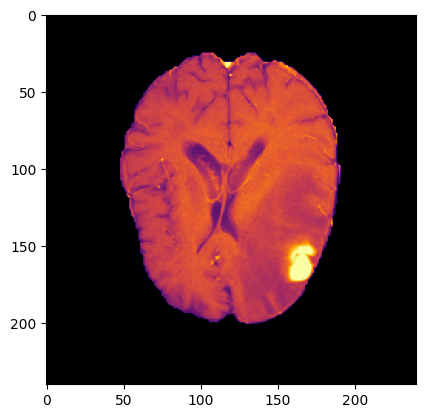

In [27]:
images = merge_and_transpose_images(rotate_90_deg(load_patient("sub-02063373")))
plt.imshow(images[80,:,:,0], cmap = "inferno")

shape: (155, 240, 240, 4)
Max value: 1.0
Min value: 0.0


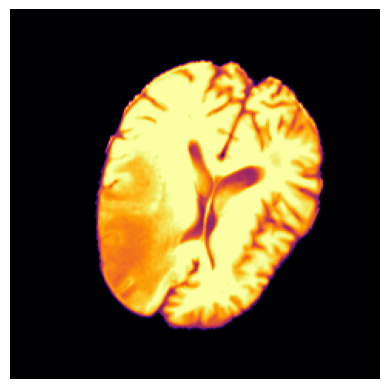

In [48]:
patient_images = prepare_images("sub-02063373")
print(f"shape: {patient_images.shape}")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    tf.keras.layers.RandomBrightness(factor = (-0.2, 0.4), value_range=(0, 1)),
    #tf.keras.layers.RandomContrast(0.5), # consider removing the random contrast layer as that causes pixel values to go beyond 1
    tf.keras.layers.RandomRotation(factor = (-0.07, 0.07), fill_mode = "nearest"),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.05,
        width_factor = 0.05,
        fill_mode = "nearest"
    )
])

#consider adding some noise

augmented_images = data_augmentation(patient_images)

plt.imshow(np.array(augmented_images[80,:,:,1]), cmap="inferno")
plt.axis("off")

print("Max value:", np.array(augmented_images).max())
print("Min value:", np.array(augmented_images).min())

### Write all the training information to TFRecord

In [ ]:
# To-Do:
# shuffle training_patients
# create new tfr file
# go through list of sex, age, created image and primary and write to file
# fucking work

path_to_tfr = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/patient_data_2classes.tfrecord")

def write_to_tfr(patient_id, sex, age, primary):

    image = prepare_images(patient_id)
    imag_data = image.tobytes()

    #sex_data = bytes(sex, "utf-8")

    patient_example = Example(
        features = Features(
            feature = {
                "image": Feature(BytesList(value=imag_data)),
                "sex": Feature(BytesList(value=[sex])),
                "age": Feature(Int64List(value=[age])),
                "primary": Feature(Int64List(value=[primary]))
            }
        )
    )

    with tf.io.TFRecordWriter(path_to_tfr) as f:
        f.write(patient_example.SerializeToString())

write_to_tfr("sub-01641510", sex_array[0], training_patients["age"][0], primary=two_classes_primaries[0])


# Assuming you have your dataset in the following format
dataset = [
    {'sex': [1, 0], 'age': 25, 'primary': 1, 'image': np.random.rand(32, 32, 32, 3)},
    {'sex': [0, 1], 'age': 30, 'primary': 0, 'image': np.random.rand(32, 32, 32, 3)},
    # Add more entries as needed
]

# Function to serialize example
def serialize_example(sex, age, primary, image):
    feature = {
        'sex': tf.train.Feature(int64_list=tf.train.Int64List(value=sex)),
        'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
        'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image[:, :, :, :]).numpy()])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Define the output TFRecord file
output_file = 'dataset.tfrecord'

# Write the dataset to TFRecord
with tf.io.TFRecordWriter(output_file) as writer:
    for data in dataset:
        example = serialize_example(data['sex'], data['age'], data['primary'], data['image'])
        writer.write(example)


 

In [2]:
path_to_tfr = "/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/patient_data_2classes.tfrecord"
path_to_testing_tfr = "/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/testing_patient_data_2classes.tfrecord"


In [54]:
def serialize_patient(patientID, sex, age, primary):

    image_data = prepare_images(patientID)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value= sex)),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
            }   
        )
    )

    return patient_example.SerializeToString()

# sex_example = sex_encoded[0]
# id_example = training_patients["participant_id"][0]
# age_example = training_patients["age"][0]
# primary_example = two_classes_primaries[0]
# print(sex_example, id_example, age_example, primary_example)

# Write the dataset to TFRecord
options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset
with tf.io.TFRecordWriter(path_to_tfr, options) as writer:

    for i in tqdm(range(len(training_patients))): # iter over all entities in the dataframe

        sex = sex_encoded[i]
        id = training_patients["participant_id"][i]
        age = training_patients["age"][i]
        primary = two_classes_primaries[i]
        example = serialize_patient(id, sex, age, primary)
        writer.write(example)

100%|██████████| 491/491 [3:27:22<00:00, 25.34s/it]  


Create a TFRecord File for testing

In [53]:
path_to_testing_tfr = "/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/testing_patient_data_2classes.tfrecord"

def serialize_patient(patientID, sex, age, primary):

    image_data = prepare_images(patientID)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value= sex)),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
            }   
        )
    )

    return patient_example.SerializeToString()


# Write the dataset to TFRecord
options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset
with tf.io.TFRecordWriter(path_to_testing_tfr, options) as writer:

    for i in tqdm(range(12)): # iter over all entities in the dataframe (prev. 8)

        sex = sex_encoded[i]
        id = training_patients["participant_id"][i]
        age = training_patients["age"][i]
        primary = two_classes_primaries[i]
        example = serialize_patient(id, sex, age, primary)
        writer.write(example)

100%|██████████| 12/12 [05:09<00:00, 25.80s/it]


### Read TFRecord File

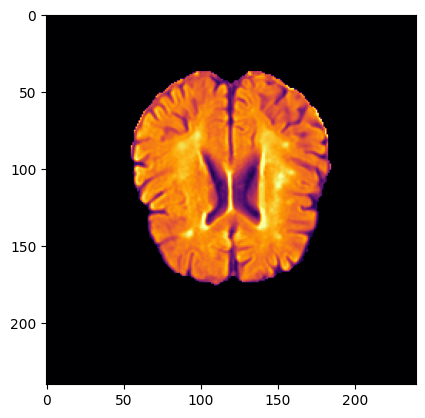

In [3]:

feature_description = {
    "image": tf.io.FixedLenFeature([155, 240, 240, 4], tf.float32),
    "sex": tf.io.FixedLenFeature([2], tf.int64, default_value=[0,0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, [155, 240, 240, 4]) #[149, 185, 155, 4] = old size
    
    return image, example["sex"], example["age"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
for image, sex, age, primary in test_image:
    numpy_image = image.numpy()
    plt.imshow(numpy_image[90,:,:,0], cmap = "inferno")

# Data Augmentation - Volumentation

In [66]:
from volumentations import *

def get_augmentation():
    return Compose([Flip(2, p=1),
                    Rotate((-30, 30),(0,0),  (0,0), p=0),
                    RandomGamma(p=1)],
                    p=1.0)
#GaussianNoise(var_limit=(0, 5), p=0.2),
# Rotate((-15, 15), (0, 0), (0, 0), p=0.5),
#                     Flip(0, p=0.5),
#                     Flip(1, p=0.5),
#                     Flip(2, p=0.5),
#                     ElasticTransform((0, 0.25), interpolation=2, p=0.1),
#                     RandomGamma(gamma_limit=(0.5, 1.5), p=0.2)]

def augmentor(img):
    aug = get_augmentation()
    data = {'image': img}
    aug_data = aug(**data)
    img = aug_data['image']
    return np.ndarray.astype(img , np.float32)

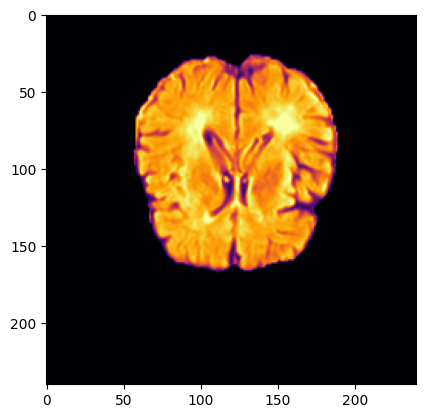

In [89]:

feature_description = {
    "image": tf.io.FixedLenFeature([155, 240, 240, 4], tf.float32),
    "sex": tf.io.FixedLenFeature([2], tf.int64, default_value=[0,0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, [155, 240, 240, 4])
    image = data_augmentation(image)
    #image = tf.numpy_function(augmentor, [image], tf.float32)

    return image, example["sex"], example["age"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)



# numpy_image = parsed_dataset.get_single_element()[0].numpy()
# plt.imshow(numpy_image[80,:,:,0], cmap = "inferno")

test_image = parsed_dataset.take(1)
for image, sex, age, primary in test_image:
    numpy_image = image.numpy()
    plt.imshow(numpy_image[80,:,:,0], cmap = "inferno")